## Analysis of Joost et al. (2016) intrafollicular epidermis scRNA-seq data

We analyse the scRNA-seq data from [Joost et al. (2016)](https://doi.org/10.1016/j.cels.2016.08.010), in order to understand how to better cluster with scanpy and also to see how we can use cell cluster labels to improve on cell-cell communication.

We first load the relevant packages.

In [97]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3 # Possible values: (0) errors, (1) warnings, (2) info, (3) hints
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 80, 
                              facecolor='white')

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.2 statsmodels==0.12.0rc0 python-igraph==0.8.2 leidenalg==0.8.2


Read in the data, which has been stored as a text file. To save on time, we also store the results in a HDF5 file.

In [2]:
results_file = 'joost2016.h5ad'

In [3]:
joostdata = sc.read_text('/Users/axelalmet/Documents/CellCellCommunicationModelling/Data/Joost2016/expression.txt').transpose()
joostdata

AnnData object with n_obs × n_vars = 1422 × 24378

Filter out cells that have an abnormally low gene expression count and genes that are expressed in fewer than 3 cells.

normalizing counts per cell
    finished (0:00:00)


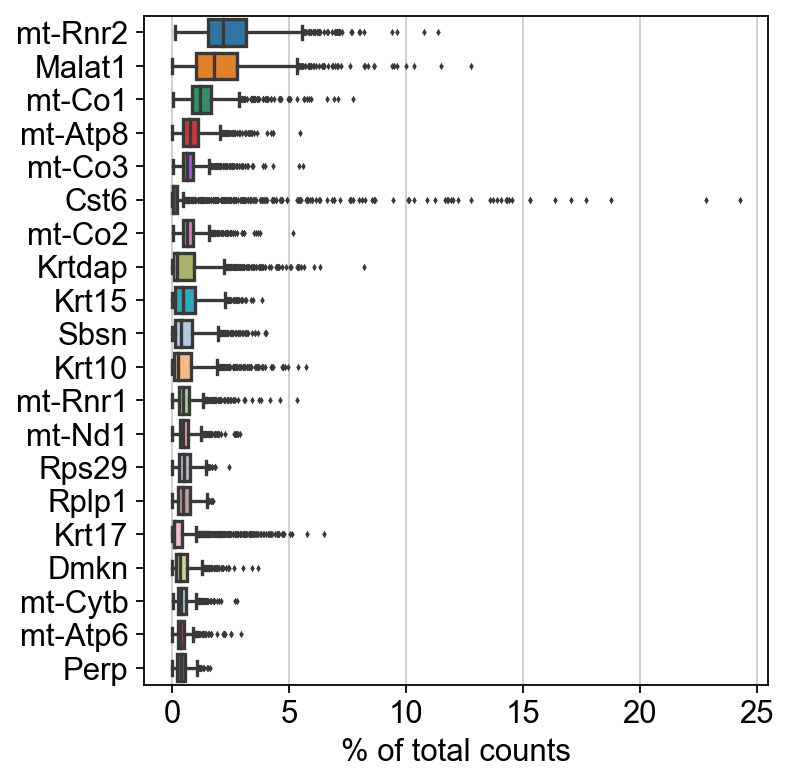

In [4]:
sc.pl.highest_expr_genes(joostdata, n_top=20)

In [5]:
sc.pp.filter_cells(joostdata, min_genes=200)
sc.pp.filter_genes(joostdata, min_cells=3)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 5666 genes that are detected in less than 3 cells


We also calculate mitochondrial gene expression to filter out "low-quality" cells.

In [6]:
joostdata.var['mt'] = joostdata.var_names.str.startswith('mt-') # Dictionary with 'mt' key corresponding to genes that start with MT-
sc.pp.calculate_qc_metrics(joostdata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) # To be honest, I don't know what these options do.

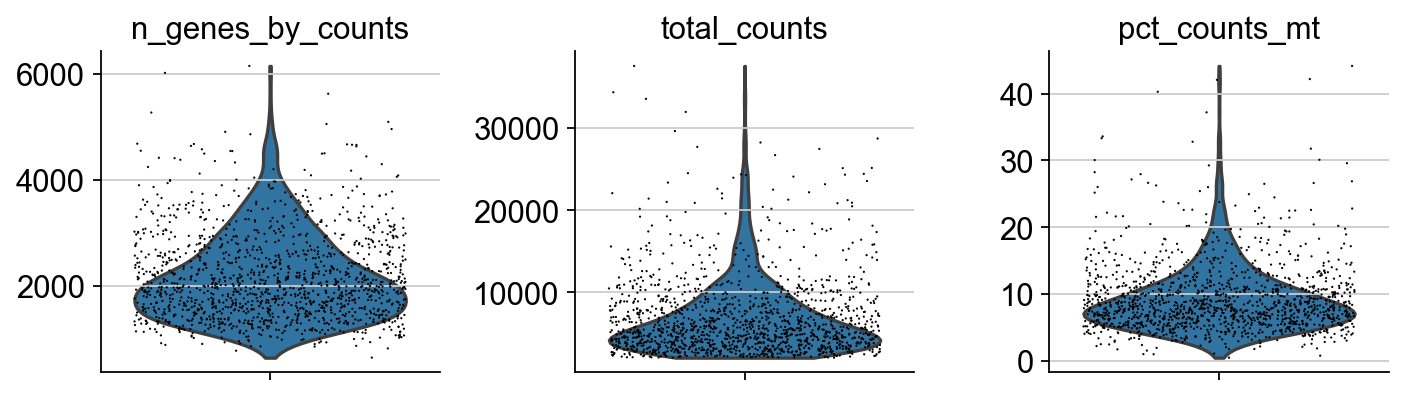

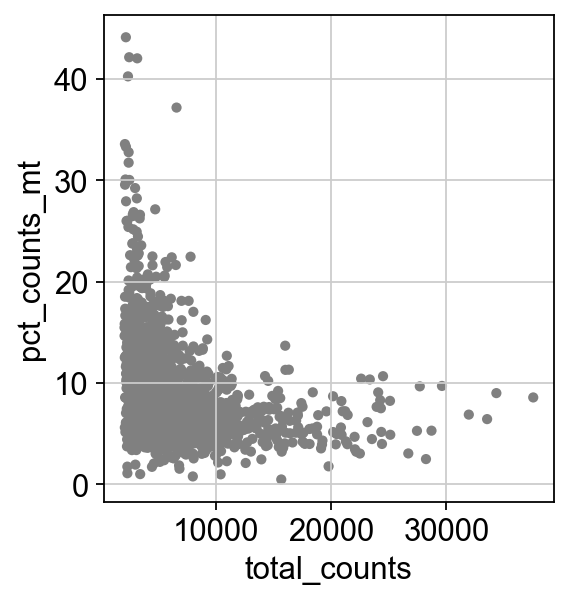

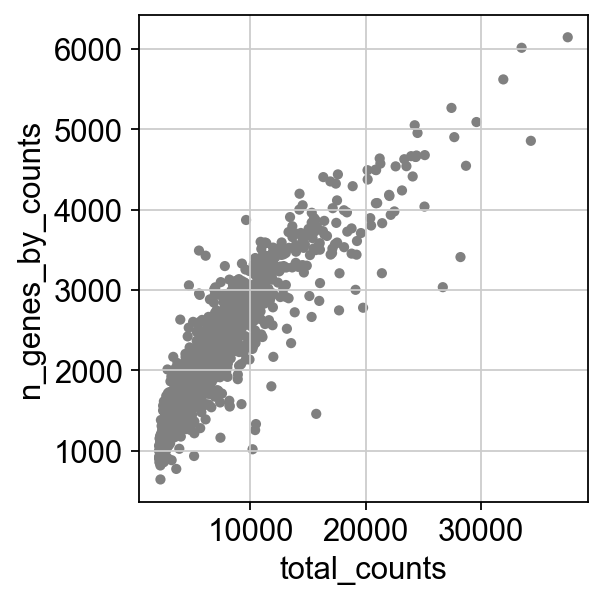

In [7]:
sc.pl.violin(joostdata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(joostdata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(joostdata, x='total_counts', y='n_genes_by_counts')

In [8]:
joostdata = joostdata[joostdata.obs.n_genes_by_counts < 3000, :] # Remove cells with abnormally high gene expression counts
joostdata = joostdata[joostdata.obs.pct_counts_mt < 10, :] # Remove cells with abnormally high mitochondrial gene expression

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [9]:
sc.pp.normalize_total(joostdata, target_sum=1e4)
sc.pp.log1p(joostdata)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


We now identify the highly-variable genes.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


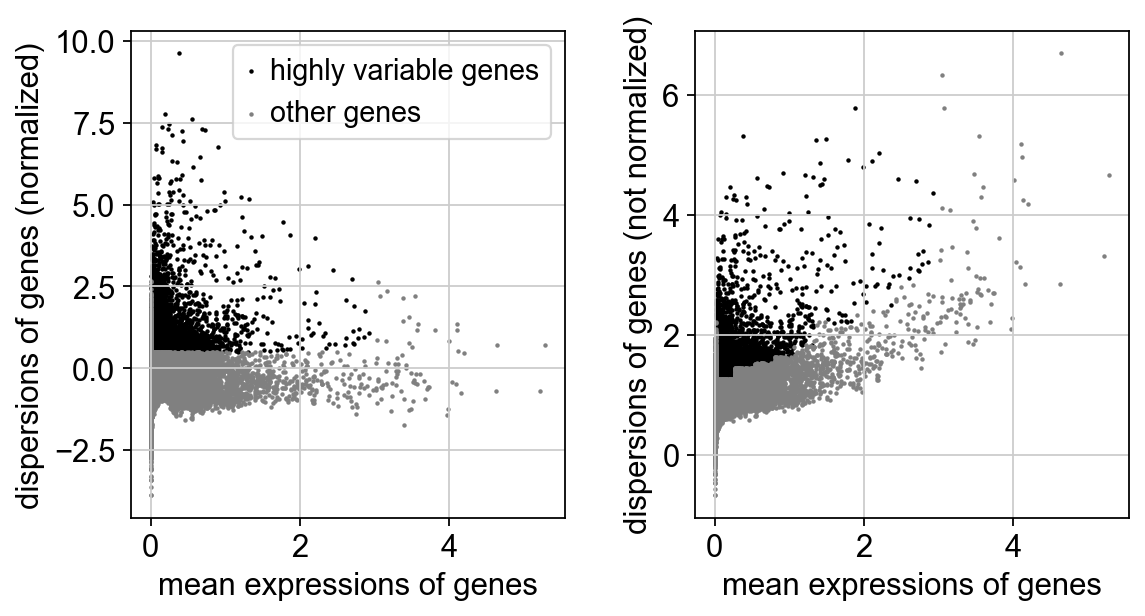

In [10]:
sc.pp.highly_variable_genes(joostdata, min_mean=0.0125, max_mean=3, min_disp=0.5) # No idea what these parameters mean.
sc.pl.highly_variable_genes(joostdata)

In [11]:
joostdata.raw = joostdata # Save the raw data for later, just in case.

In [12]:
joostdata = joostdata[:, joostdata.var.highly_variable] # Filter out genes that do not vary much across cells
sc.pp.regress_out(joostdata, ['total_counts', 'pct_counts_mt']) # Regress out the poor quality cells 

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:08)


In [13]:
sc.pp.scale(joostdata, max_value=10) # Scale the data

In [14]:
sc.tl.pca(joostdata, n_comps = 40, svd_solver='arpack') # Run the PCA

computing PCA
    on highly variable genes
    with n_comps=40
    finished (0:00:00)


Let's determine the dimensionality of the dataset now. We'll plot the Elbow plot and try and also be a bit more quantitative about this.

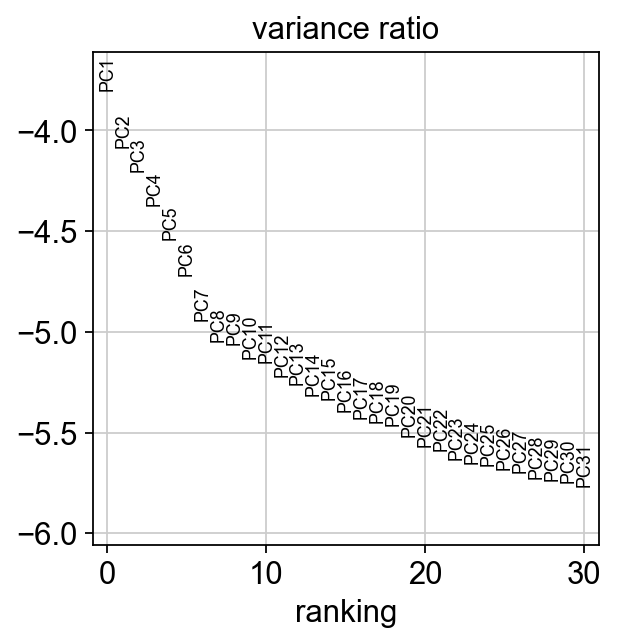

In [15]:
sc.pl.pca_variance_ratio(joostdata, log=True)

In [16]:
joost_pct = np.sqrt(joostdata.uns['pca']['variance']) / sum(np.sqrt(joostdata.uns['pca']['variance'])) * 100.0 # Determine percent of variation associated with each PC
joost_cumsum = np.cumsum(joost_pct) # Calculate cumulative percents for each PC
cumsum_indices = np.where(joost_cumsum > 90.0) # Determine which PC exhibits cumulative percent greater than 90% 
pct_indices = np.where(joost_pct < 5.0) # Determine which PC has % variation associated with the PC as less than 5
co1 = np.intersect1d(cumsum_indices, pct_indices)[0]
joost_diff = np.where(joost_pct[0:(len(joost_pct) - 1)] - joost_pct[1:(len(joost_pct))] > 0.1) # Determine the difference between variation of PC and subsequent PC
sorted_indices = np.sort(joost_diff)[0]
co2 = sorted_indices[::-1][0] + 1
num_pcs_joost = min(co1, co2)
print(num_pcs_joost)

7


We are now in a position to run the UMAP and clustering, having determined the appropriate number of PCs.

In [17]:
sc.pp.neighbors(joostdata, n_neighbors=10, n_pcs=num_pcs_joost) # Find the nearest neighbours
sc.tl.umap(joostdata) # Calculate the UMAP

computing neighbors
    using 'X_pca' with n_pcs = 7


/usr/local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [103]:
# clustering_resolutions = np.arange(0.4, 0.9, 0.05) # Initialise coarse cluster

# # Cluster over a range of resolutions to see which line up with Joost et al.'s cluster numbers (13?)
# for res in clustering_resolutions:
#     sc.tl.leiden(joostdata, resolution = res, key_added = "leiden_{:.2f}".format(res))

sc.tl.leiden(joostdata, resolution = 0.75, key_added = 'leiden')

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


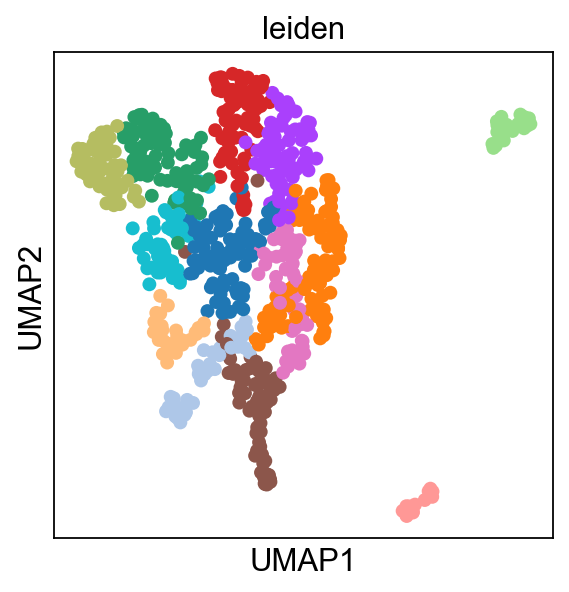

In [119]:
sc.pl.umap(joostdata, color='leiden', legend_loc = 'on_data')

Now that we've determined the clustering resolution that matches Joost et al., let's find the marker genes.

In [122]:
sc.tl.rank_genes_groups(joostdata, 'leiden', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


Examine the top 10 genes from each group.

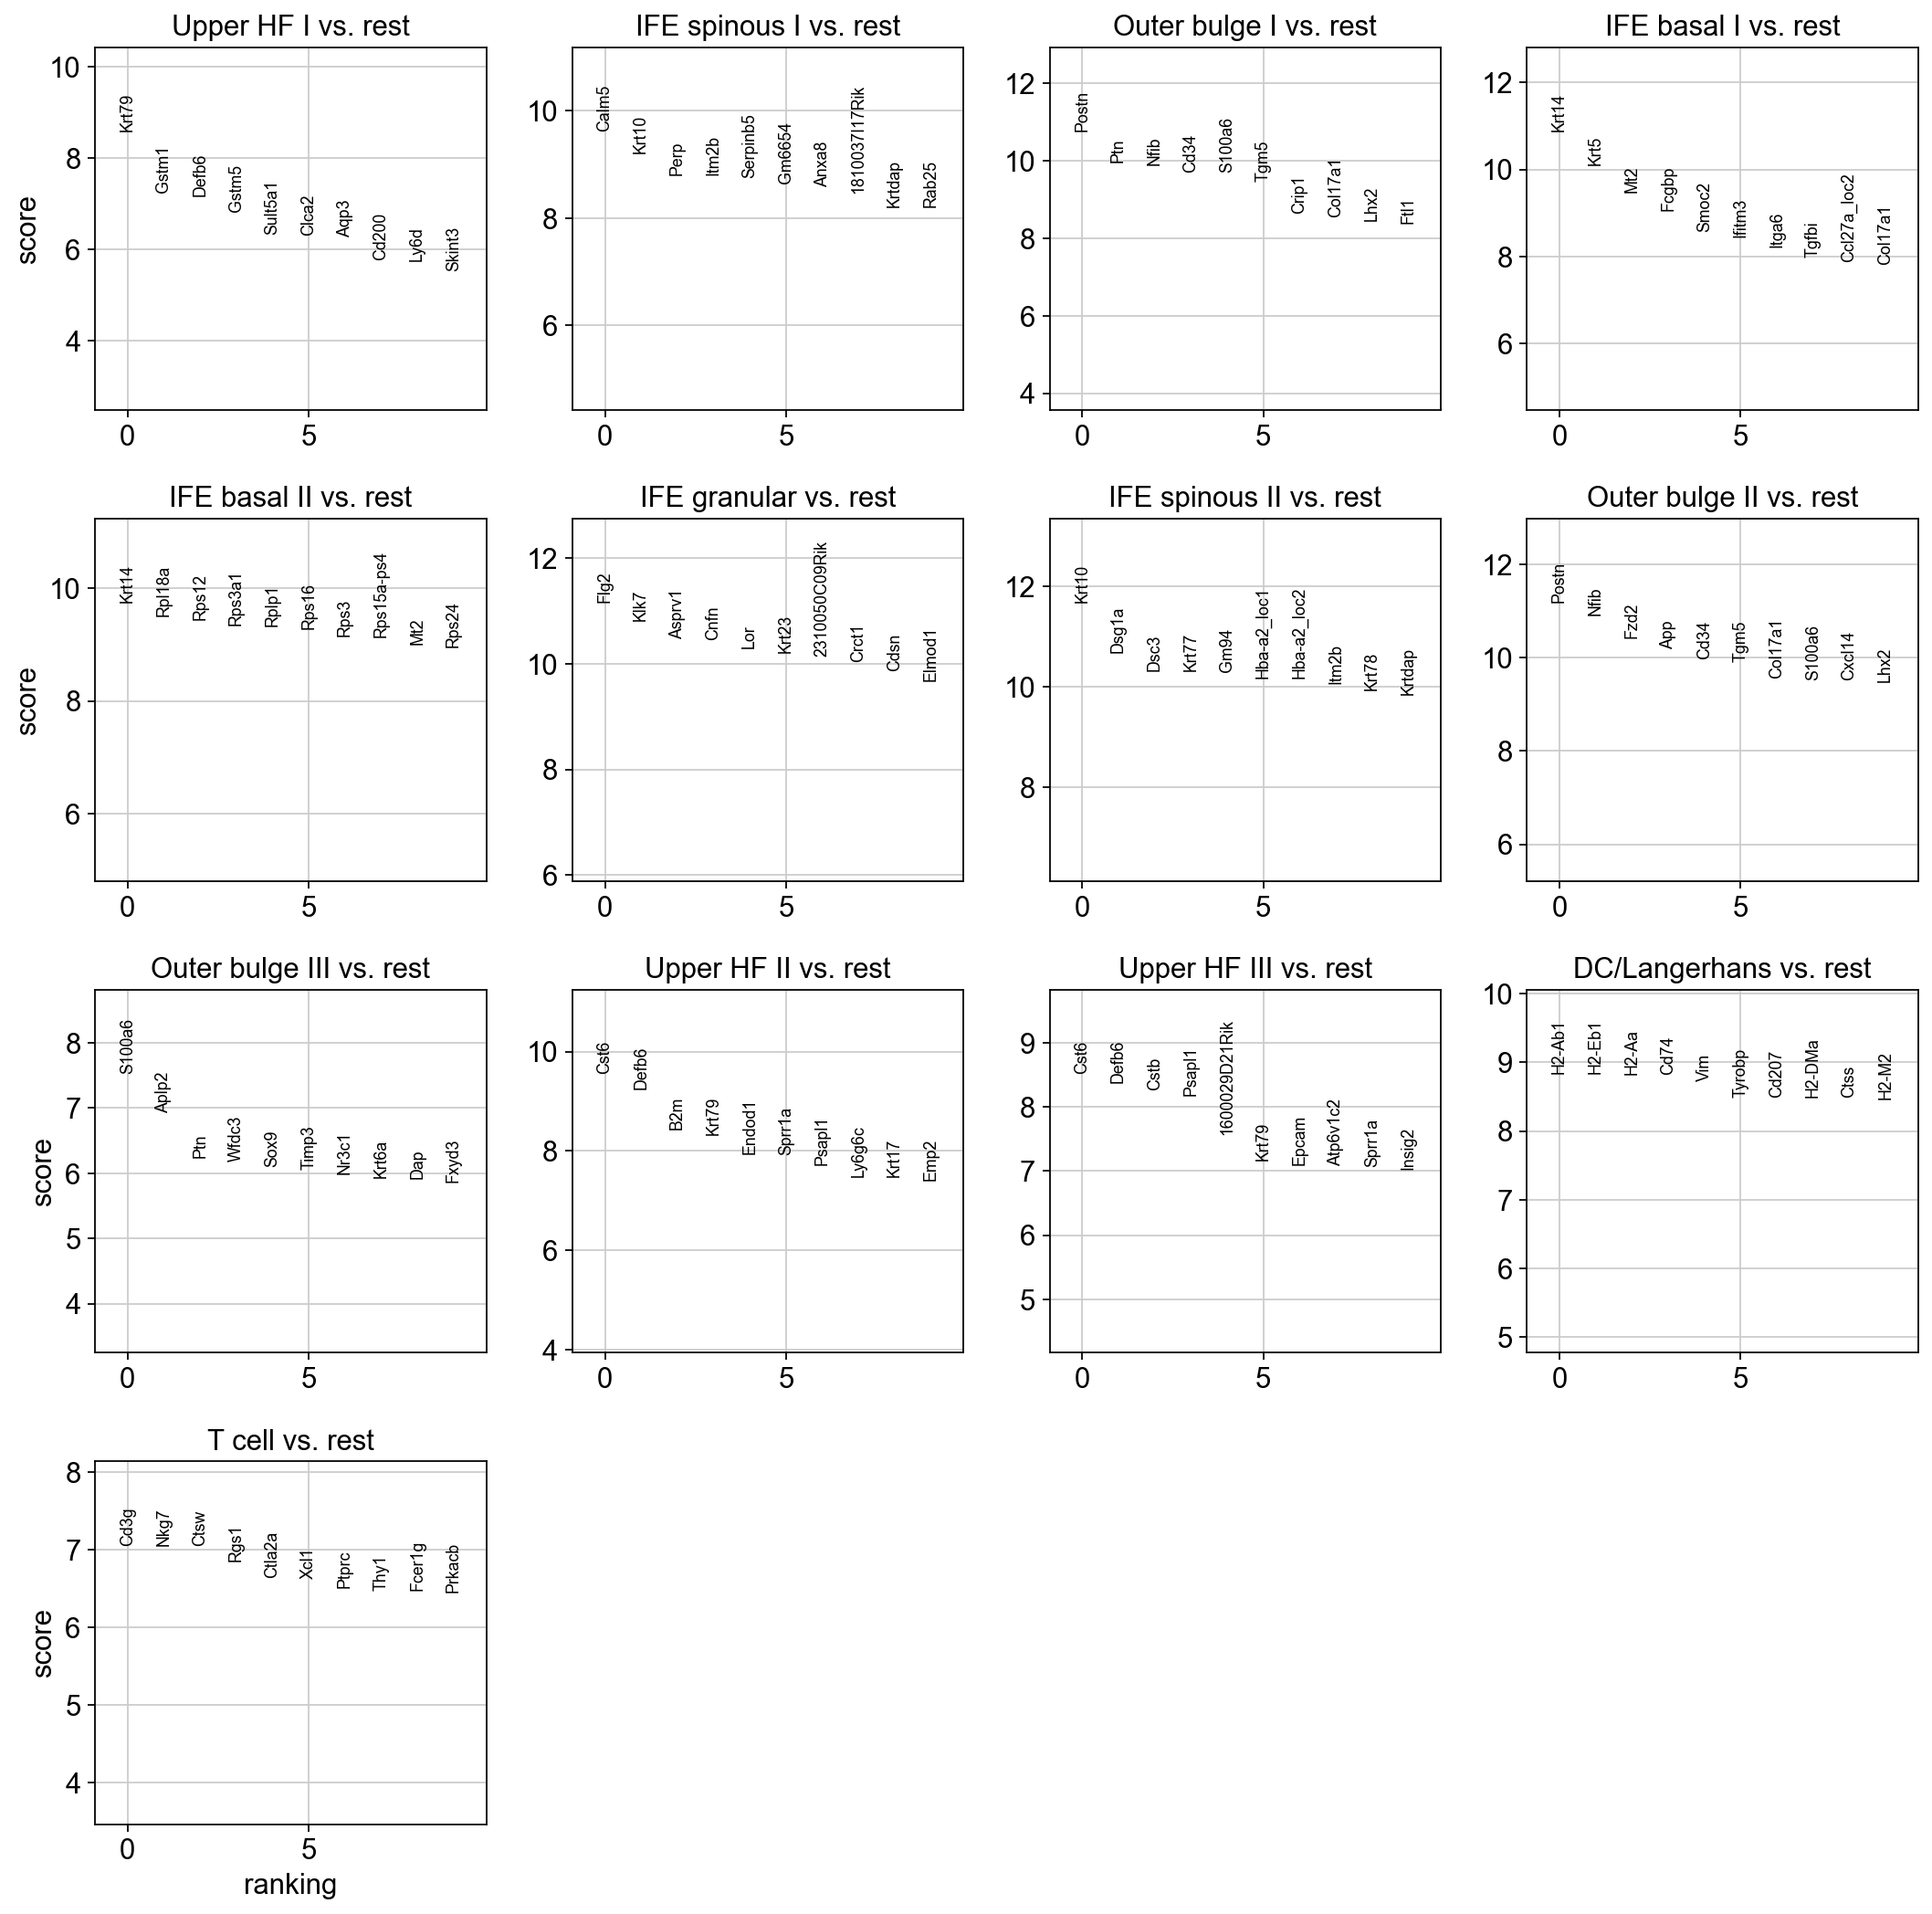

In [123]:
sc.pl.rank_genes_groups(joostdata, n_genes=10, sharey=False)

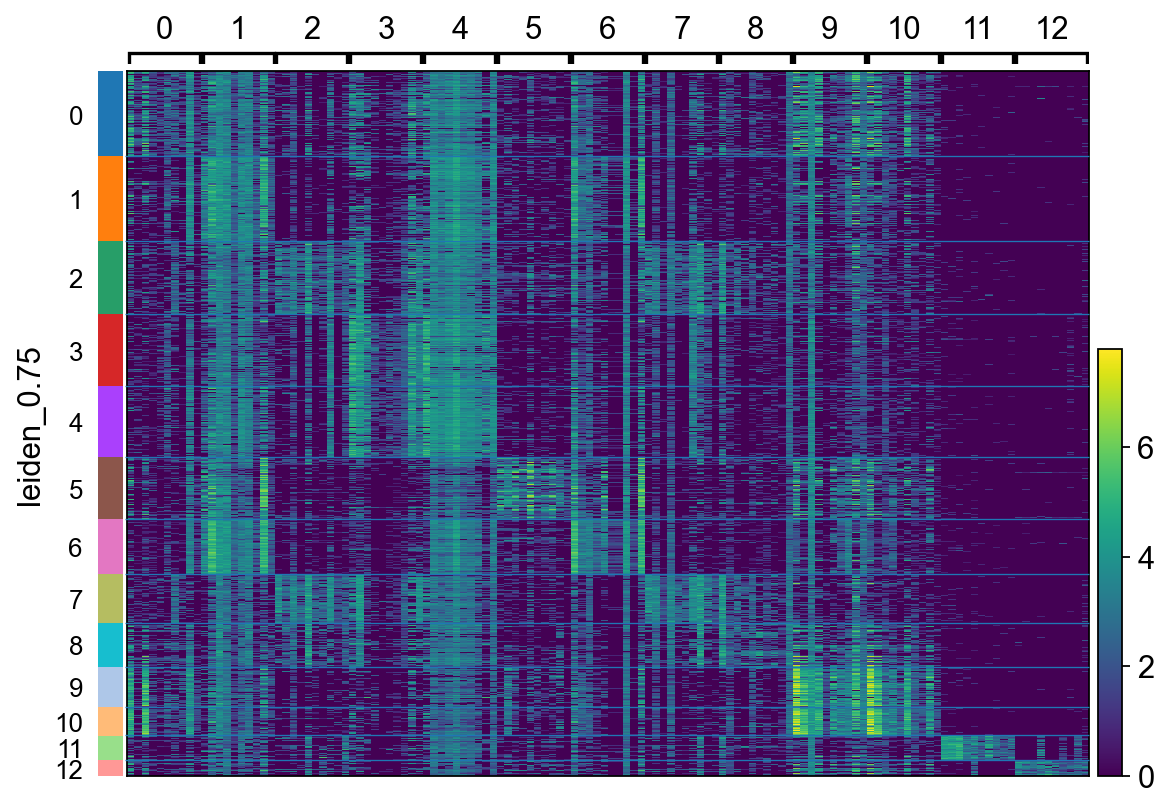

In [121]:
sc.pl.rank_genes_groups_heatmap(joostdata, n_genes=10, dendrogram = False)

In [113]:
pd.DataFrame(joostdata.uns['rank_genes_groups']['names'])['8'].head(20)

0        S100a6
1         Aplp2
2           Ptn
3         Wfdc3
4          Sox9
5         Timp3
6         Nr3c1
7         Krt6a
8           Dap
9         Fxyd3
10        Foxp1
11          App
12        Lima1
13        Efna5
14        Actn1
15        Cd24a
16    Serpinb11
17        Adcy1
18         Nfib
19        Fxyd6
Name: 8, dtype: object

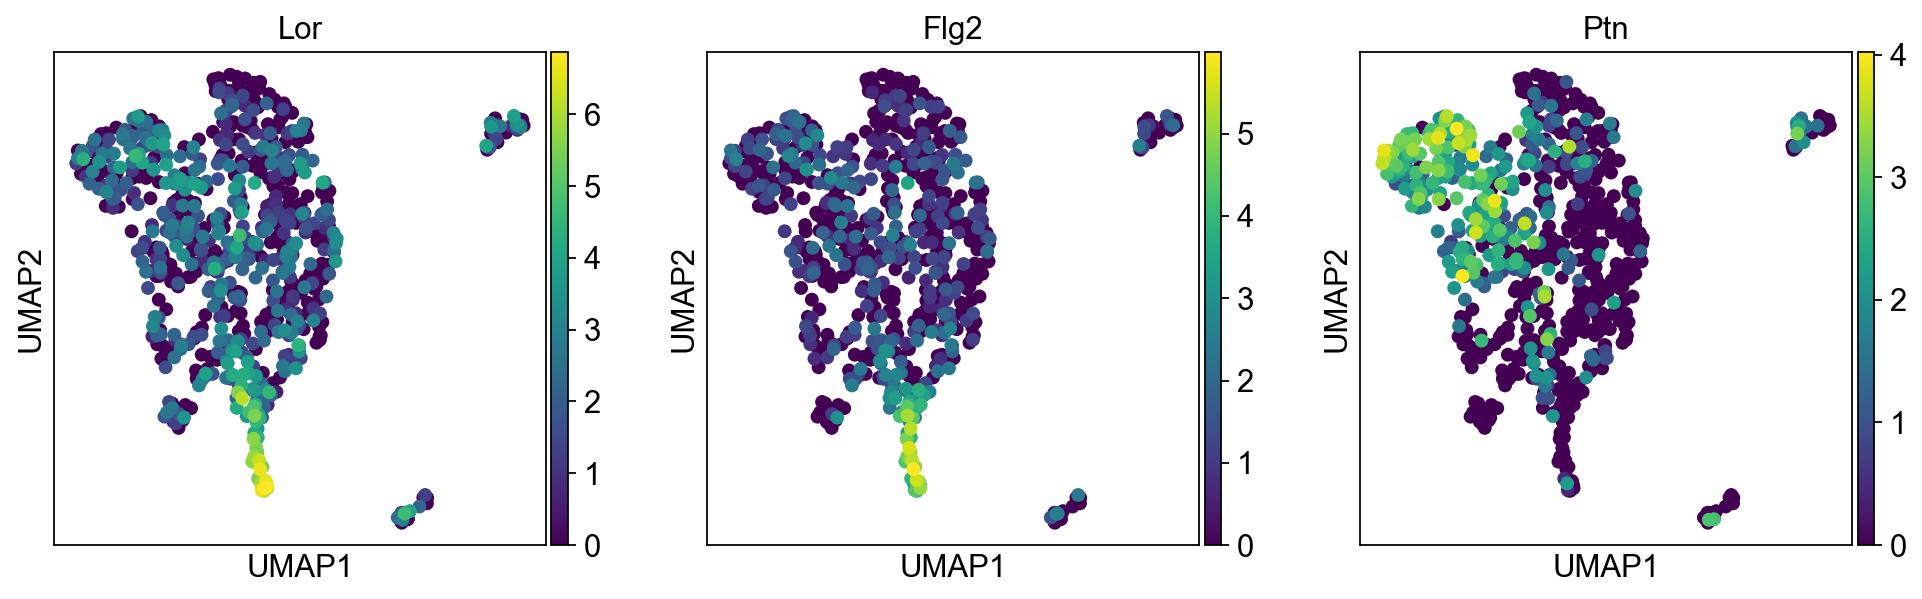

In [120]:
sc.pl.umap(joostdata, color=['Lor', 'Flg2', 'Ptn'])

Having identified the cell clusters, we can now assign new cell identities, based on their gene expression, as such:

0 - Upper HF I; 1 - IFE spinous I; 2 - Outer bulge I; 3 - IFE basal I; 4 - IFE basal II;
5 - IFE granular; 6 - IFE spinous II; 7 - Outer bulge II; 8 - Outer bulge III; 9 - Upper HF II;
10 - Upper HF III; 11 - DC/Langerhans cell; 12 - T cell

In [117]:
# Rename the cells as such:
new_cluster_names = ['Upper HF I', 'IFE spinous I', 'Outer bulge I', 'IFE basal I',\
                     'IFE basal II', 'IFE granular', 'IFE spinous II', 'Outer bulge II', \
                    'Outer bulge III', 'Upper HF II', 'Upper HF III', 'DC/Langerhans', \
                    'T cell']
joostdata.rename_categories('leiden', new_cluster_names)

In [124]:
joostdata.write(results_file) # Save the results